In [1]:
import numpy as np
import typing as ty
import matplotlib.pylab as plt
from lava.magma.core.learning.constants import GradedSpikeCfg

from lava.utils.weightutils import SignMode

from lava.magma.core.learning.learning_rule import Loihi3FLearningRule

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.clp.prototype_lif.process import PrototypeLIF
from lava.proc.clp.novelty_detector.process import NoveltyDetector
from lava.proc.clp.nsm.process import Readout
from lava.proc.io.source import RingBuffer, PySendModelFixed
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense, LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

In [78]:
# Load COIL-100 data (selected, well-separated 42 objects)
with open('coil100_features_separated_objs.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

n_samples = X.shape[0]
n_classes = len(np.unique(y))

y = y + 1  # the label==0 is reserved for no information on communication channel
# Normalize the vectors
X = X / np.expand_dims(np.linalg.norm(X, axis=1), axis=1)

In [79]:
print(X.shape, y.shape)

(3024, 2048) (3024,)


In [104]:
from sklearn.model_selection import train_test_split
n_train_per_class = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(72-n_train_per_class)/72, random_state=42, stratify=y)

In [105]:
X_train = X_train[np.argsort(y_train),:]
y_train = y_train[np.argsort(y_train)]

In [106]:
X_test = X_test[np.argsort(y_test),:][::23, :]
y_test = y_test[np.argsort(y_test)][::23]


In [107]:
print(X_train.shape)
print(X_test.shape)

(126, 2048)
(126, 2048)


In [108]:
# Convert normalized input patterns to 8-bit fixed-point patterns
b_fraction = 8  # The fraction of the fixed point representation used to translate floating point input to graded spikes
inp_pattern_fixed = np.floor(np.vstack((X_train, X_test)) * 2 ** b_fraction).astype(np.int32)

[ 1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8  8  8
  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16 16
 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23 24 24 24
 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 32 32 32
 33 33 33 34 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 39 39 40 40 40
 41 41 41 42 42 42]


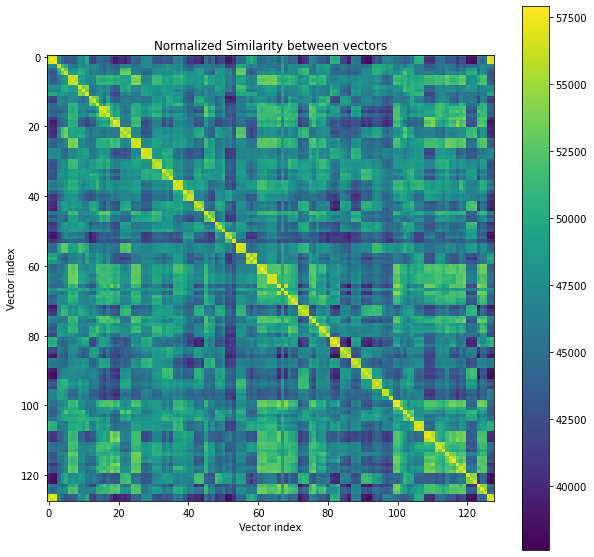

In [101]:
sims = np.dot(inp_pattern_fixed, inp_pattern_fixed.T)
plt.figure(figsize=(10,10))
plt.imshow(sims)
plt.colorbar()
plt.title("Normalized Similarity between vectors")
plt.xlabel("Vector index")
plt.ylabel("Vector index")
print(y_train)

In [102]:
sims

array([[57139, 56112, 56199, ..., 47343, 56157, 56116],
       [56112, 57389, 56987, ..., 45142, 57323, 56341],
       [56199, 56987, 57585, ..., 45050, 57088, 56670],
       ...,
       [47343, 45142, 45050, ..., 57143, 45154, 44624],
       [56157, 57323, 57088, ..., 45154, 57496, 56453],
       [56116, 56341, 56670, ..., 44624, 56453, 57479]])


Sector Averages:
[[56432.66666667 45116.11111111 44351.22222222 ... 42844.88888889
  38952.33333333 45872.11111111]
 [45116.11111111 51716.66666667 47332.55555556 ... 45493.88888889
  48001.44444444 46537.66666667]
 [44351.22222222 47332.55555556 55830.         ... 52480.22222222
  47749.55555556 51494.11111111]
 ...
 [42844.88888889 45493.88888889 52480.22222222 ... 54995.66666667
  45385.33333333 52524.77777778]
 [38952.33333333 48001.44444444 47749.55555556 ... 45385.33333333
  54040.33333333 43031.        ]
 [45872.11111111 46537.66666667 51494.11111111 ... 52524.77777778
  43031.         54490.33333333]]


(array([[1., 0., 1., 0., 2., 1., 0., 1., 3., 6., 0., 7., 5., 2., 1., 2.,
         1., 3., 1., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         3., 2., 0., 0., 4., 1., 3., 3., 4., 5., 2., 3., 0., 8.]]),
 array([48322.44444444, 48594.80740741, 48867.17037037, 49139.53333333,
        49411.8962963 , 49684.25925926, 49956.62222222, 50228.98518519,
        50501.34814815, 50773.71111111, 51046.07407407, 51318.43703704,
        51590.8       , 51863.16296296, 52135.52592593, 52407.88888889,
        52680.25185185, 52952.61481481, 53224.97777778, 53497.34074074,
        53769.7037037 , 54042.06666667, 54314.42962963, 54586.79259259,
        54859.15555556, 55131.51851852, 55403.88148148, 55676.24444444,
        55948.60740741, 56220.97037037, 56493.33333333]),
 <a list of 2 BarContainer objects>)

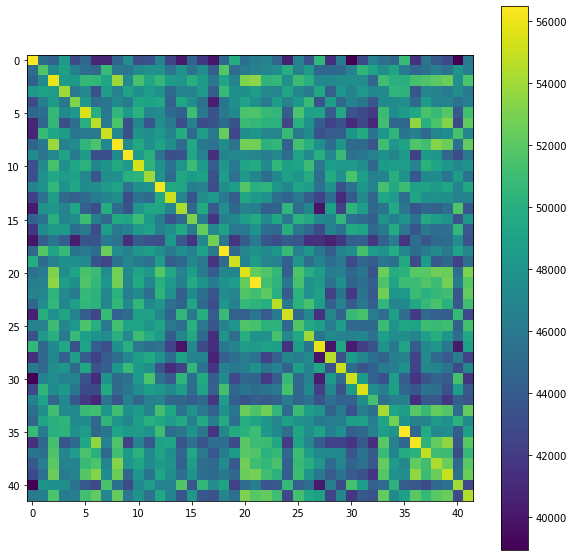

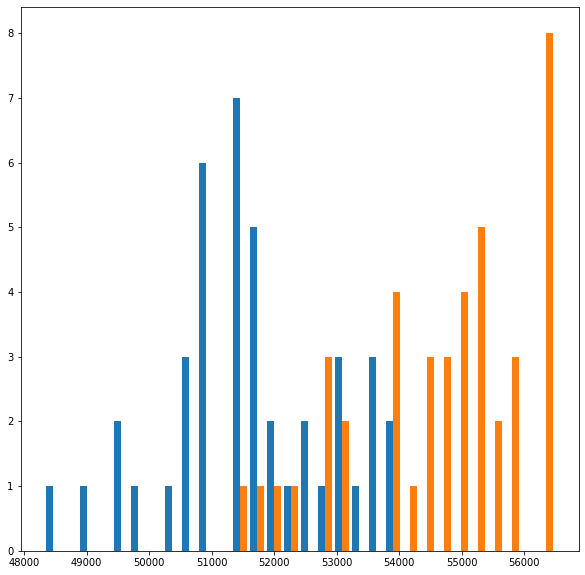

In [103]:
import numpy as np

def calculate_sector_averages(matrix, k):
    n = matrix.shape[0]
    averages = []
    
    for i in range(n // k):
        for j in range(n // k):
            sector = matrix[i * k : (i + 1) * k, j * k : (j + 1) * k]
            if i==j:
                sector_average = np.sum(sector)/(k**2-k)
            else:
                sector_average = np.mean(sector)
            averages.append(sector_average)

    averages = np.array(averages).reshape((int(n/k), int(n/k)))
    return averages

# Example usage
k = 3
np.fill_diagonal(sims, 0)
averages = calculate_sector_averages(sims, k)

print("\nSector Averages:")
print(averages)

plt.figure(figsize=(10,10))
plt.imshow(averages)
plt.colorbar()

plt.figure(figsize=(10,10))
plt.hist(np.sort(averages, axis=0)[-2:].T, bins=30)

In [441]:
np.sort(averages, axis=0)[-2:].T

array([[56690.        , 56698.        ],
       [53280.88888889, 53356.77777778],
       [55975.        , 56119.77777778],
       [54958.77777778, 55101.        ],
       [56769.44444444, 56825.        ],
       [56656.        , 56701.77777778],
       [56661.        , 56673.55555556],
       [56568.77777778, 56663.        ],
       [56646.22222222, 56665.66666667],
       [56807.66666667, 56825.        ],
       [56647.11111111, 56831.66666667],
       [56853.66666667, 56917.11111111],
       [56686.88888889, 56733.        ],
       [56684.66666667, 56779.22222222],
       [56917.11111111, 57017.33333333],
       [56576.55555556, 56626.44444444],
       [56684.66666667, 56756.        ],
       [56679.11111111, 56724.44444444],
       [56617.88888889, 56624.        ],
       [56687.55555556, 56798.88888889],
       [56626.77777778, 56641.88888889],
       [56699.33333333, 56735.88888889],
       [56642.22222222, 56761.33333333],
       [56798.88888889, 56831.66666667],
       [56750.  

In [56]:
n_train_samples

126

In [115]:
# General params
t_wait = 10  # the waiting window for novelty detection after input injection
n_protos = 200  # number of the prototypes
n_features = X_train.shape[1]  # the feature dimension of the input
n_train_samples = X_train.shape[0]
n_test_samples = X_test.shape[0]
n_total_samples = n_train_samples + n_test_samples
# The time difference between two consecutive inputs
n_steps_per_sample = 35
# number of time steps that the processes will run
num_steps = (n_total_samples) * n_steps_per_sample

# PrototypeLIF neural dynamics parameters
du = 600
dv = 900
vth = 114000

# Learning rule parameters
x1_tau = 65535  # Pre-trace decay constant. The high values means no decay
t_epoch = 1  # Epoch length

# Config for writing graded payload of the input spike to x1-trace
graded_spike_cfg = GradedSpikeCfg.OVERWRITE

In [116]:
n_steps = 10
v_hist = np.zeros(shape=(n_steps,3), dtype=np.int32)
v = np.zeros(shape=(1,3), dtype=np.int32)
u = np.zeros(shape=(1,3), dtype=np.int32)
activation_in_list = np.zeros(shape=(n_steps,3), dtype=np.int32)
activation_in_list[0, :] = [51000, 52000, 53000]
ds_offset = 1
dm_offset = 0
isbiasscaled = False
isthrscaled = False
effective_bias = 0
# Let's define some bit-widths from Loihi
# State variables u and v are 24-bits wide
uv_bitwidth = 24
max_uv_val = 2 ** (uv_bitwidth - 1)
# Decays need an MSB alignment with 12-bits
decay_shift = 12
decay_unity = 2**decay_shift
# Threshold and incoming activation are MSB-aligned using 6-bits
vth_shift = 6
act_shift = 6

decay_const_u = du + ds_offset

for t in range(n_steps):

    
    # Below, u is promoted to int64 to avoid overflow of the product
    # between u and decay constant beyond int32. Subsequent right shift by
    # 12 brings us back within 24-bits (and hence, within 32-bits)
    decayed_curr = np.int64(u) * (decay_unity - decay_const_u)
    decayed_curr = np.sign(decayed_curr) * np.right_shift(
        np.abs(decayed_curr), decay_shift
    )
    decayed_curr = np.int32(decayed_curr)
    # Hardware left-shifts synaptic input for MSB alignment
    activation_in = np.left_shift(activation_in_list[t,:], act_shift)
    # Add synptic input to decayed current
    decayed_curr += activation_in
    # Check if value of current is within bounds of 24-bit. Overflows are
    # handled by wrapping around modulo 2 ** 23. E.g., (2 ** 23) + k
    # becomes k and -(2**23 + k) becomes -k
    wrapped_curr = np.where(
        decayed_curr > max_uv_val,
        decayed_curr - 2 * max_uv_val,
        decayed_curr,
    )
    wrapped_curr = np.where(
        wrapped_curr <= -max_uv_val,
        decayed_curr + 2 * max_uv_val,
        wrapped_curr,
    )
    u[:] = wrapped_curr
    # Update voltage
    # --------------
    decay_const_v = dv + dm_offset
    
    neg_voltage_limit = -np.int32(max_uv_val) + 1
    pos_voltage_limit = np.int32(max_uv_val) - 1
    # Decaying voltage similar to current. See the comment above to
    # understand the need for each of the operations below.
    decayed_volt = np.int64(v) * (decay_unity - decay_const_v)
    decayed_volt = np.sign(decayed_volt) * np.right_shift(
        np.abs(decayed_volt), decay_shift
    )
    decayed_volt = np.int32(decayed_volt)
    updated_volt = decayed_volt + u + effective_bias
    v[:] = np.clip(updated_volt, neg_voltage_limit, pos_voltage_limit)
    v_hist[t,:] = (v/64)

In [117]:
v_hist

array([[ 51000,  52000,  53000],
       [ 83310,  84944,  86577],
       [102136, 104139, 106142],
       [111378, 113561, 115745],
       [113939, 116173, 118408],
       [111972, 114167, 116363],
       [107051, 109150, 111249],
       [100324, 102291, 104259],
       [ 92611,  94427,  96243],
       [ 84490,  86146,  87803]])

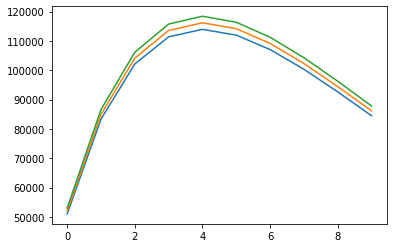

In [118]:
plt.plot(v_hist)

In [119]:
num_steps

8820

In [120]:
n_features

2048

In [121]:
n_protos

200

In [122]:
# No pattern is stored yet. None of the prototypes are allocated
weights_proto = np.zeros(shape=(n_protos, n_features))

# Weights also should be in the fixed point representation if starting with some non-zero weights.
weights_proto = weights_proto * 2 ** b_fraction

In [123]:
# Novelty detection input connection weights  (all-to-one connections)
weights_in_aval = np.ones(shape=(1, n_features))
weights_out_aval = np.ones(shape=(1, n_protos))

In [124]:
# The graded spike array for input
s_pattern_inp = np.zeros((n_features, num_steps))



# Create input spike pattter that inject these inputs every n_steps_per_sample time step
s_pattern_inp[:, 1:-1:n_steps_per_sample] = inp_pattern_fixed.T

In [125]:
# The graded spike array for the user-provided label 
s_user_label = np.zeros((1, num_steps))
s_user_label[:, 14:n_train_samples*n_steps_per_sample:n_steps_per_sample] = y_train.T
# s_user_label[0, 9] = 1
# s_user_label[0, 27] = 2
# s_user_label[0, 97] = 2

In [126]:
# Create a custom LearningRule. Define dw as a string
dw = "2^-3*y1*x1*y0"

learning_rule = Loihi3FLearningRule(dw=dw,
                                    x1_tau=x1_tau,
                                    t_epoch=t_epoch)

In [127]:
# Processes
data_input = RingBuffer(data=s_pattern_inp)

user_label_input = RingBuffer(data=s_user_label)

nvl_det = NoveltyDetector(t_wait=t_wait,
                          n_protos=n_protos)

readout_layer = Readout(n_protos=n_protos,
                        proto_labels=np.zeros((1, n_protos)))

# Prototype Lif Process
prototypes = PrototypeLIF(du=du,
                          dv=dv,
                          bias_mant=0,
                          bias_exp=0,
                          vth=vth,
                          shape=(n_protos,),
                          name='lif_prototypes',
                          sign_mode=SignMode.EXCITATORY,
                          learning_rule=learning_rule)

dense_proto = LearningDense(weights=weights_proto,
                            learning_rule=learning_rule,
                            name="proto_weights",
                            num_message_bits=8,
                            graded_spike_cfg=graded_spike_cfg)

# Incoming (Dense) connection processes for NoveltyDetector
dense_in_aval = Dense(weights=weights_in_aval)
dense_out_aval = Dense(weights=weights_out_aval)

weights_wta = -255*np.ones(shape=(n_protos, n_protos))
dense_wta = Dense(weights=weights_wta, weight_exp=4)

# Monitor processes
monitor_nvl = Monitor()
monitor_protos = Monitor()
monitor_v = Monitor()
monitor_u = Monitor()
monitor_preds = Monitor()

In [128]:
# Connections

# Data input -> PrototypeLIF connection
data_input.s_out.connect(dense_proto.s_in)
dense_proto.a_out.connect(prototypes.a_in)

# Data input -> NoveltyDetector connection for input_available signal
data_input.s_out.connect(dense_in_aval.s_in)
dense_in_aval.a_out.connect(nvl_det.input_aval_in)

# PrototypeLIF -> NoveltyDetector connection for output_available signal
prototypes.s_out.connect(dense_out_aval.s_in)
dense_out_aval.a_out.connect(nvl_det.output_aval_in)

# Novelty detector to prototypes connection
nvl_det.novelty_detected_out.connect(prototypes.a_third_factor_in)

# lif_prototypes.s_out.connect(proto_weights_dense.s_in_bap)
prototypes.s_out_bap.connect(dense_proto.s_in_bap)

# Sending y1 spike
prototypes.s_out_y1.connect(dense_proto.s_in_y1)

# Prototype Neurons' outputs connect to the inference input of the Readout process
prototypes.s_out.connect(readout_layer.inference_in)
user_label_input.s_out.connect(readout_layer.label_in)

# WTA of prototypes
prototypes.s_out.connect(dense_wta.s_in)
dense_wta.a_out.connect(prototypes.a_in)

In [129]:
# Probe novelty detector and prototypes
monitor_nvl.probe(target=nvl_det.novelty_detected_out, num_steps=num_steps)
monitor_protos.probe(target=prototypes.s_out, num_steps=num_steps)
monitor_preds.probe(target=readout_layer.user_output, num_steps=num_steps)
# monitor_v.probe(target=prototypes.v, num_steps=num_steps)
# monitor_u.probe(target=prototypes.u, num_steps=num_steps)
# monitor_weights.probe(target=dense_proto.weights, num_steps=num_steps)

In [130]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

# Get results
novelty_spikes = monitor_nvl.get_data()
novelty_spikes = novelty_spikes[nvl_det.name][
    nvl_det.novelty_detected_out.name]

proto_spikes = monitor_protos.get_data()
proto_spikes = proto_spikes[prototypes.name][prototypes.s_out.name]

preds = monitor_preds.get_data()[readout_layer.name][
    readout_layer.user_output.name]

# voltages = monitor_v.get_data()[prototypes.name][
#     prototypes.v.name]

# currents = monitor_u.get_data()[prototypes.name][
#     prototypes.u.name]

# result_weights = monitor_weights.get_data()
# result_weights = result_weights[dense_proto.name][
#     dense_proto.weights.name]

# Stop the run
prototypes.stop()


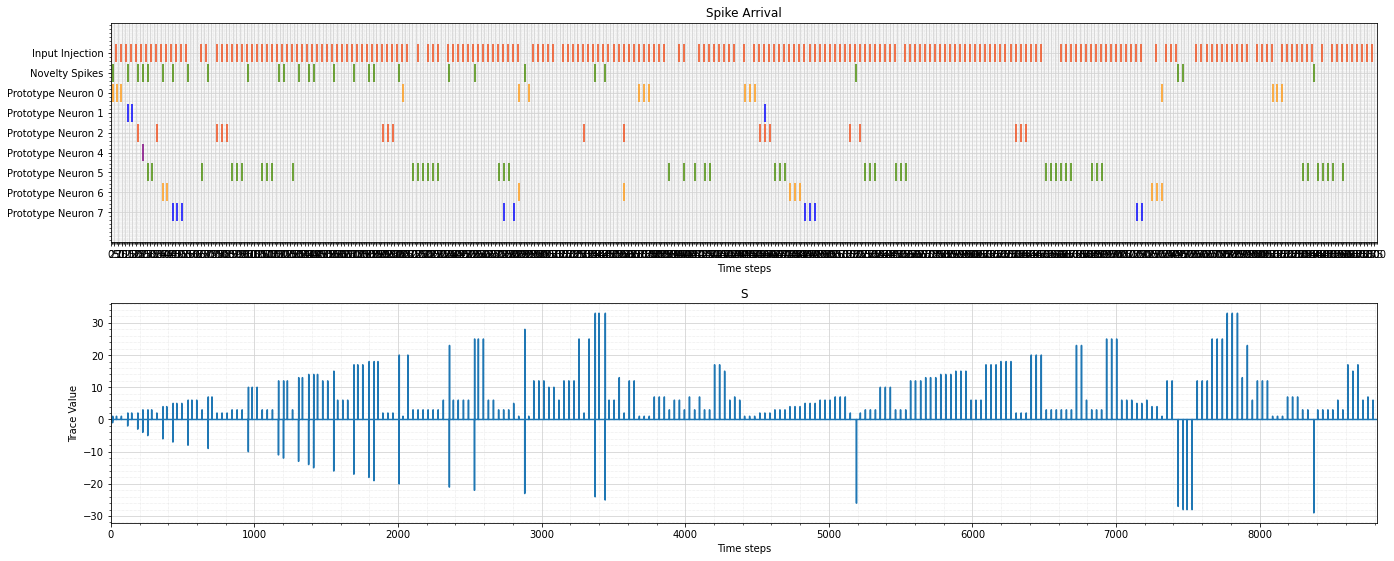

In [131]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(novelty_spikes[:, :])[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 2', 'Prototype Neuron 1',
                'Prototype Neuron 0',
                'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','#458b00','#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

In [132]:
y_pred = np.maximum.reduceat(preds.copy(),np.r_[0:len(preds):n_steps_per_sample])[42*3:]

In [133]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

0.42063492063492064


In [134]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9603174603174603


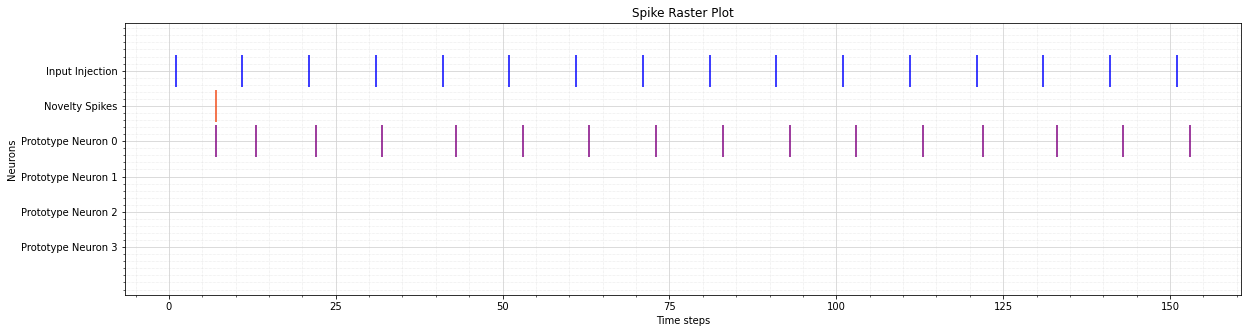

In [72]:


plot_spikes(spikes=[np.where(proto_spikes[:, 3])[0],
                    np.where(proto_spikes[:, 2])[0],
                    np.where(proto_spikes[:, 1])[0],
                    np.where(proto_spikes[:, 0])[0],
                    np.where(novelty_spikes[:, :])[0],
                    np.where(s_pattern_inp[0, :])[0]],
                    figsize=(20,5), 
            legend=['Prototype Neuron 3','Prototype Neuron 2', 
                    'Prototype Neuron 1','Prototype Neuron 0',
                    'Novelty Spikes', 'Input Injection'],
            colors=['blue', '#ff9912', '#458b00', 'purple', '#f14a16','blue'],
            title='Spike Raster Plot',
            num_steps=num_steps)

In [33]:
3600000/64/2**16

0.858306884765625